In [1]:
from functools import partial

import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper', font_scale=1.4)

In [38]:
def ficks_law(u):
    """Finite difference scheme for Fick's law"""
    lapl = np.empty(len(u))
    lapl[0] = u[-1] - 2*u[0] + u[1]
    lapl[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    lapl[-1] = u[-2] - 2*u[-1] + u[0]
    return lapl

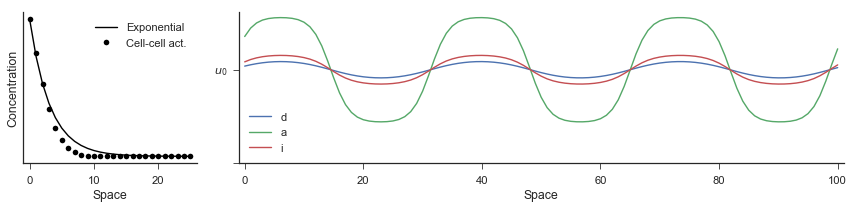

In [138]:
x = np.arange(0, 101, 1)


D = 0.1
d = 0.01

def source(coupling, _, c):
    dcdt = D*coupling(c) - d*c
    dcdt[0] = 0
    return dcdt
    
    
offset = 1

def turing(coupling, _, uv):
#     assert (uv > 0).all()
    d = uv[:101]
    a = uv[101:202]
    i = uv[202:]

#     dddt = a + ficks_law(d) - d
#     dadt = 0.6*(a - offset) - (i - offset) - (a - offset)**3 + 2*d - 2*a
#     didt = 1.5*(a - offset) - 2*(i - offset) + 25*ficks_law(i)

#     dddt = i + 25*ficks_law(d) - d
#     dadt = 0.6*(a - offset) - (i - offset) - (a - offset)**3 + 2*ficks_law(a)
#     didt = 1.5*(a - offset) - 2*(i - offset) + 2*d - 2*i
    
    dddt = i + 25*ficks_law(d) - d
    dadt = 0.6*(a - offset) - (i - offset) - (a - offset)**3 + 2*ficks_law(a)
    didt = 1.5*(a - offset) - 2*(i - offset) + 8*d - 8*i

    return np.concatenate((dddt, dadt, didt))


def test_diffusion_model(coupling):
    """Plot gradient from source and Turing pattern"""
    plt.figure(figsize=(12, 3))

    analytic_gradient = np.exp(-np.sqrt(d/D)*x)
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e3], c_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 0))
    plt.plot(x[:26], analytic_gradient[:26], 'k')
    plt.plot(x[:26], c.y[:, -1][:26], 'ko')
    plt.legend(['Exponential', coupling.description])
    plt.xlabel('Space')
    plt.xlim([-1, 26])
    plt.ylabel('Concentration')
    plt.yticks([])

    uv_0 = offset + np.random.rand(len(x)*3)/100
    uv = solve_ivp(partial(turing, coupling), [0, 1e3], uv_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan=3)
    plt.plot(x, uv.y[:, -1][:101], label='d')
    plt.plot(x, uv.y[:, -1][101:202], label='a')
    plt.plot(x, uv.y[:, -1][202:], label='i')
    plt.xlabel('Space')
    plt.xlim([-1, 101])
    plt.yticks([0, offset], ['', '$u_0$'])
    plt.legend()

    sns.despine()
    plt.tight_layout()
    plt.savefig(coupling.description.replace(' ', '_').replace("'", '').replace('.', '') + '.png', 
                dpi=300)
    plt.show()
    
    
def cell_cell_act(u):
    diff = np.empty(len(u))
    diff[0] = u[-1] + u[1]
    diff[1:-1] = u[:-2] + u[2:]
    diff[-1] = u[-2] + u[0]
    return diff/20


cell_cell_act.description = 'Cell-cell act.'
test_diffusion_model(cell_cell_act)